In [ ]:
# =============================================
# Menopause Prediction (RHQ060_predicted)
# =============================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
import joblib
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# 1️⃣ Load dataset
# -------------------------------
df = pd.read_csv("Merged_Dataset.csv")


# -------------------------------
# 2️⃣ Target and top features
# -------------------------------
target = "RHQ060"
top_features = ['RIDAGEYR', 'LBXBPB', 'RHQ420', 'LBXBCD',
                'RHQ160', 'LBXBMN', 'LBXTHG', 'LBXBSE']
categorical_features = ['RHQ160', 'RHQ420']

# -------------------------------
# 3️⃣ Split dataset
# -------------------------------
X = df[top_features].copy()
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------------
# 4️⃣ Encode categorical features
# -------------------------------
cat_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    cat_encoders[col] = le

# -------------------------------
# 5️⃣ Impute missing values
# -------------------------------
imputer = SimpleImputer(strategy="mean")
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
y_train = y_train.fillna(y_train.mean())
y_test = y_test.fillna(y_test.mean())

# -------------------------------
# 6️⃣ Normalize features
# -------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------------------
# 7️⃣ Define models
# -------------------------------
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=200, random_state=42, n_jobs=-1)
}

# -------------------------------
# 8️⃣ Cross-validation scoring
# -------------------------------
scoring = {
    "MAE": make_scorer(mean_absolute_error),
    "RMSE": make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))),
    "R2": make_scorer(r2_score)
}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# -------------------------------
# 9️⃣ Train and evaluate models
# -------------------------------
results = []
for model_name, model in models.items():
    scores = cross_validate(model, X_train_scaled, y_train, cv=kf, scoring=scoring, n_jobs=-1)
    results.append({
        "Model": model_name,
        "MAE": round(scores["test_MAE"].mean(), 4),
        "RMSE": round(scores["test_RMSE"].mean(), 4),
        "R2": round(scores["test_R2"].mean(), 4)
    })

results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False).reset_index(drop=True)
results_df.to_csv("Menopause_TopFeatures_Model_Results.csv", index=False)
print("\n✅ Model training complete! Top results:\n", results_df)

# -------------------------------
# 🔟 Save model and preprocessing
# -------------------------------
best_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
best_model.fit(X_train_scaled, y_train)

joblib.dump(best_model, "Menopause_RF_Model.pkl")
joblib.dump(cat_encoders, "Menopause_CatEncoders.pkl")
joblib.dump(imputer, "Menopause_Imputer.pkl")
joblib.dump(scaler, "Menopause_Scaler.pkl")
print("✅ Model and preprocessing saved!")



✅ Model training complete! Top results:
                Model     MAE     RMSE      R2
0      Random Forest  6.0080   8.5698  0.5204
1            XGBoost  6.3825   8.9203  0.4799
2  Linear Regression  8.5113  10.0124  0.3465
✅ Model and preprocessing saved!


In [12]:
# =============================================
# Menopause Prediction Model (RHQ031 target)
# =============================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# -------------------------------
# 1️⃣ Load dataset
# -------------------------------
df = pd.read_csv("Merged_Dataset.csv")

# -------------------------------
# 2️⃣ Define target & clean data
# -------------------------------
target = "RHQ060_predicted"  # Age to be predicted
df = df[df[target].notna()]  # remove rows with missing age

# -------------------------------
# 3️⃣ Select top correlated features
# -------------------------------
features = [
    'RIDAGEYR', 'LBXBPB', 'RHQ420',
    'LBXBCD', 'RHQ160', 'LBXBMN',
    'LBXTHG', 'LBXBSE'
]

X = df[features]
y = df[target]

# Save raw features used
with open("Menopause_features.txt", "w") as f:
    for feat in features:
        f.write(feat + "\n")

# -------------------------------
# 4️⃣ Split dataset
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------------
# 🧹 Ensure correct data types
# -------------------------------
# Convert 'Yes'/'No' columns to string (categorical)
yes_no_cols = ['RHQ420']  # Add any other categorical features
for col in yes_no_cols:
    df[col] = df[col].astype(str)

# -------------------------------
# 5️⃣ Identify categorical & numeric columns
# -------------------------------
categorical_features = [col for col in X.columns if X[col].dtype == 'object']
numeric_features = [col for col in X.columns if col not in categorical_features]

# -------------------------------
# 6️⃣ Preprocessing pipeline
# -------------------------------
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# -------------------------------
# 7️⃣ Combine preprocessor + model
# -------------------------------
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# -------------------------------
# 8️⃣ Train model
# -------------------------------
model.fit(X_train, y_train)

# -------------------------------
# 9️⃣ Evaluate
# -------------------------------
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n✅ Menopause Model Results:")
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

# -------------------------------
# 🔟 Save full pipeline + model
# -------------------------------
joblib.dump(model, "Menopause_Pipeline_Model.joblib")
print("\n💾 Saved Menopause_Pipeline_Model.joblib successfully!")



✅ Menopause Model Results:
MAE: 5.8896, RMSE: 8.4792, R²: 0.5517

💾 Saved Menopause_Pipeline_Model.joblib successfully!


In [ ]:
# =============================================
# 🔍 Test the Menopause (Age Prediction) Model
# =============================================

import pandas as pd
import joblib

# -------------------------------
# 1️⃣ Load the saved model
# -------------------------------
model = joblib.load("Menopause_Pipeline_Model.joblib")
print("✅ Model loaded successfully!")

# -------------------------------
# 2️⃣ Prepare new test data
# -------------------------------
# ⚠️ Ensure all columns match the feature names used during training:
# ['RIDAGEYR', 'LBXBPB', 'RHQ420', 'LBXBCD', 'RHQ160', 'LBXBMN', 'LBXTHG', 'LBXBSE']

test_data = pd.DataFrame([{
    'RIDAGEYR': 45,     # Example: current age
    'LBXBPB': 2.4,      # Blood lead (µg/dL)
    'RHQ420': 'Yes',    # Ever taken birth control pills?
    'LBXBCD': 0.35,     # Blood cadmium (µg/L)
    'RHQ160': 2,        # How many times have been pregnant?
    'LBXBMN': 1.10,     # Blood manganese (µg/L)
    'LBXTHG': 0.75,     # Blood mercury (µg/L)
    'LBXBSE': 0.65      # Blood selenium (µg/L)
}])

print("\n📘 Input Data:")
display(test_data)

# -------------------------------
# 3️⃣ Predict using the loaded model
# -------------------------------
predicted_age = model.predict(test_data)[0]

print(f"\n🎯 Predicted Age (RHQ060_predicted): {predicted_age:.2f} years")


✅ Model loaded successfully!

📘 Input Data:


,RIDAGEYR,LBXBPB,RHQ420,LBXBCD,RHQ160,LBXBMN,LBXTHG,LBXBSE
0,45,2.4,Yes,0.35,2,1.1,0.75,0.65



🎯 Predicted Age (RHQ060_predicted): 40.39 years


In [8]:
import pandas as pd
import joblib

# Load the pipeline model
model = joblib.load("Menopause_Pipeline_Model.joblib")

# Create new input with the SAME feature structure and types as training
new_data = pd.DataFrame([{
    "RIDAGEYR": 45,
    "LBXBPB": 0.5,
    "RHQ420": 0.0,
    "LBXBCD": 1.2,
    "RHQ160": 0.0,
    "LBXBMN": 0.3,
    "LBXTHG": 0.2,
    "LBXBSE": 0.45
}])

# Predict
y_pred = model.predict(new_data)

print("🧮 Predicted value:", y_pred[0])


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import joblib

# --- 1. Load data ---
df = pd.read_csv("menstrual_data.csv")

# --- 2. Define features and target ---
target = "Menstrual_Irregularity"
X = df.drop(columns=[target])
y = df[target]

# --- 3. Identify column types ---
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(exclude=['object']).columns.tolist()

print("Categorical:", categorical_cols)
print("Numeric:", numeric_cols)

# --- 4. Preprocessor ---
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# --- 5. Full pipeline ---
model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

# --- 6. Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 7. Fit model ---
model.fit(X_train, y_train)

# --- 8. Save combined pipeline ---
joblib.dump(model, "menstrual_model.joblib")

print("✅ Model + preprocessing saved as menstrual_model.joblib")
print("📜 Raw features used:", X.columns.tolist())


FileNotFoundError: [Errno 2] No such file or directory: 'menstrual_data.csv'

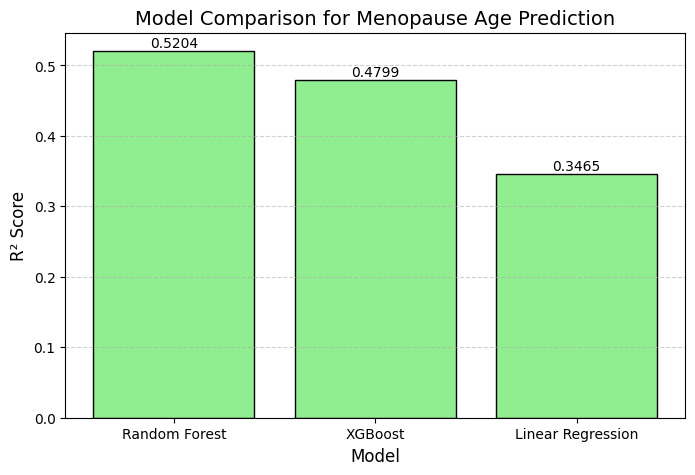

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your saved model performance
results_df = pd.read_csv("Menopause_TopFeatures_Model_Results.csv")

plt.figure(figsize=(8,5))
plt.bar(results_df["Model"], results_df["R2"], color='lightgreen', edgecolor='black')
plt.title("Model Comparison for Menopause Age Prediction", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
for i, v in enumerate(results_df["R2"]):
    plt.text(i, v + 0.005, str(v), ha='center', fontsize=10)
plt.show()


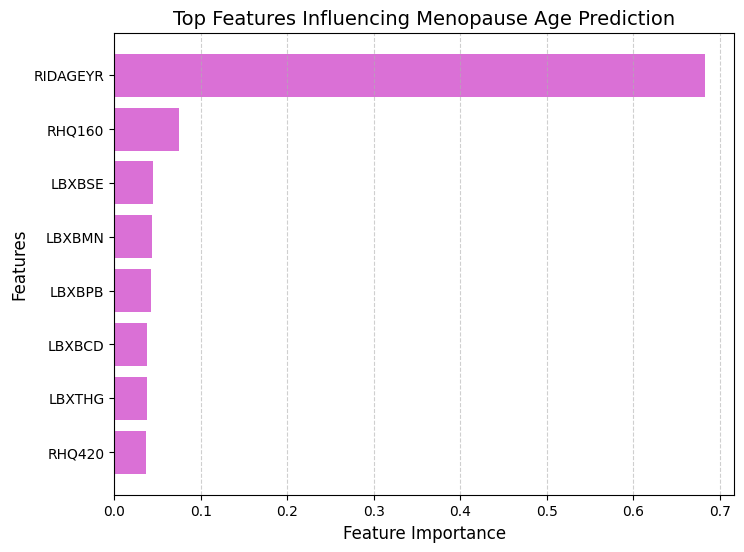

In [2]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load trained model (Random Forest)
rf_model = joblib.load("Menopause_RF_Model.pkl")
feature_names = ['RIDAGEYR', 'LBXBPB', 'RHQ420', 'LBXBCD', 'RHQ160', 'LBXBMN', 'LBXTHG', 'LBXBSE']

importances = pd.DataFrame({
    "Feature": feature_names,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=True)

plt.figure(figsize=(8,6))
plt.barh(importances["Feature"], importances["Importance"], color='orchid')
plt.title("Top Features Influencing Menopause Age Prediction", fontsize=14)
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


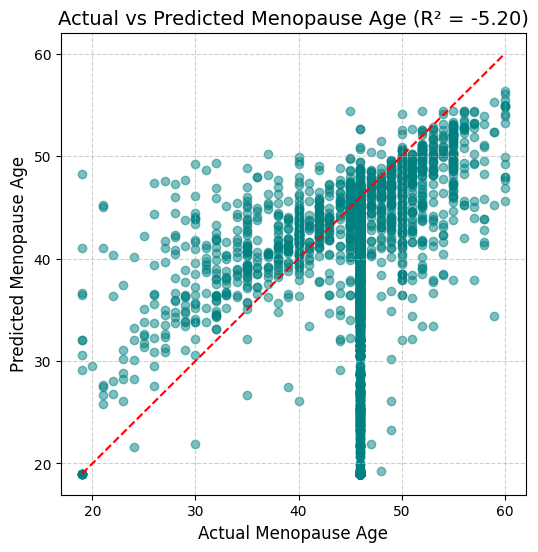

In [6]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Load model and data
pipeline = joblib.load("Menopause_Pipeline_Model.joblib")
df = pd.read_csv("Merged_Dataset.csv")

features = ['RIDAGEYR','LBXBPB','RHQ420','LBXBCD','RHQ160','LBXBMN','LBXTHG','LBXBSE']
X = df[features]
y_true = df["RHQ060"].dropna()
y_pred = pipeline.predict(X.loc[y_true.index])

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.5, color='teal')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.title(f"Actual vs Predicted Menopause Age (R² = {r2_score(y_true, y_pred):.2f})", fontsize=14)
plt.xlabel("Actual Menopause Age", fontsize=12)
plt.ylabel("Predicted Menopause Age", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


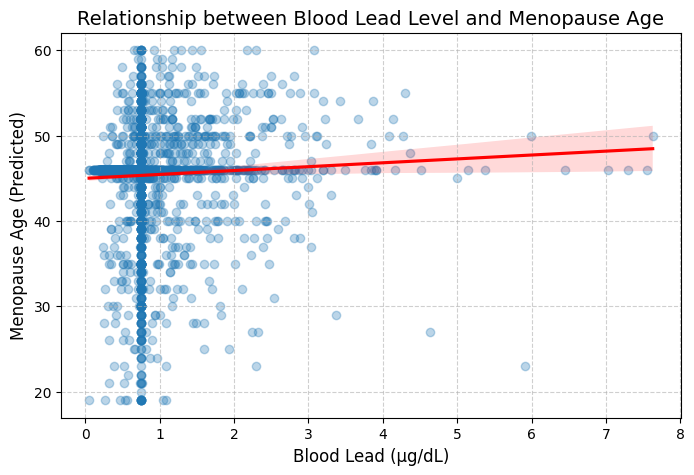

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.regplot(x=df['LBXBPB'], y=df['RHQ060'], scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title("Relationship between Blood Lead Level and Menopause Age", fontsize=14)
plt.xlabel("Blood Lead (µg/dL)", fontsize=12)
plt.ylabel("Menopause Age (Predicted)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


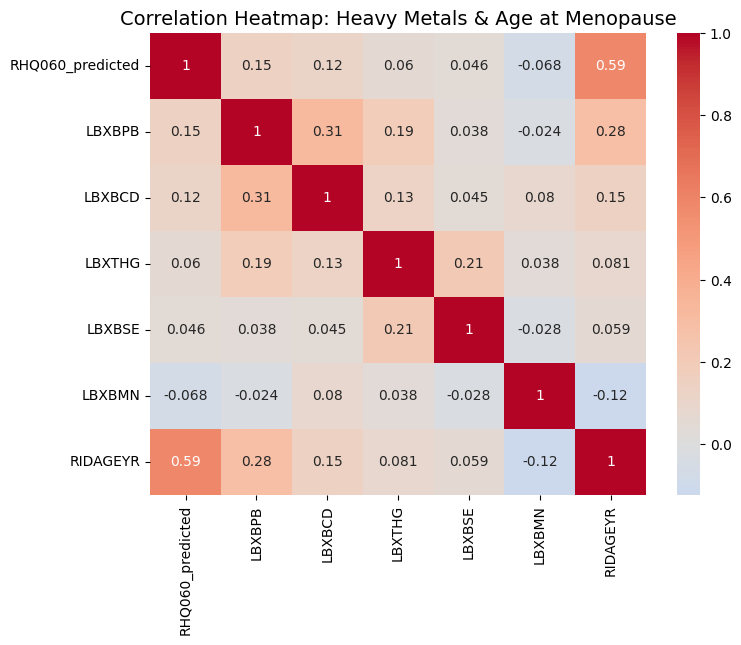

In [7]:
plt.figure(figsize=(8,6))
corr = df[['RHQ060_predicted','LBXBPB','LBXBCD','LBXTHG','LBXBSE','LBXBMN','RIDAGEYR']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap: Heavy Metals & Age at Menopause", fontsize=14)
plt.show()


In [8]:
plt.savefig("Menopause_Age_vs_Lead.png", dpi=300, bbox_inches="tight")


<Figure size 640x480 with 0 Axes>